somewhere else, do:
```
git clone https://github.com/lsst/ip_diffim.git
cd ip_diffim
source ~/lsstsw/setup.csh
#setup -t b1813 ip_diffim
#setup -k -r .
setup -t 1813 -r .
scons
```

then you will want to add `$HOME/lsstsw/miniconda/lib/python2.7/site-packages` to your `PYTHONPATH` in order to be able to import `joblib` and friends.

now edit and run the code in here.

In [1]:
import sys
from collections import namedtuple

import numpy as np
import pandas as pd

%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt

import matplotlib
matplotlib.style.use('ggplot')

from joblib import Parallel, delayed  
import multiprocessing

np.random.seed(666)

In [2]:
## LSST imports:
import lsst.utils.tests as tests
import lsst.daf.base as dafBase
#import lsst.afw.display.ds9 as ds9
import lsst.afw.image as afwImage
import lsst.afw.geom as afwGeom
import lsst.afw.table as afwTable
import lsst.afw.math as afwMath
import lsst.meas.algorithms as measAlg
import lsst.ip.diffim as ipDiffim

In [3]:
## Code updated from lsstsw/build/ip_diffim/tests/dipole.py

## Old code used a double gaussian psf which has the problem that it is pixel-oriented.
## Let's use afwMath.DoubleGaussianFunction2D() instead...
## Change parameterization to pixels - separation (in pixels) and psfWidth (pixels)

## Weird behavior, this fails the dipole lobes are not offset from each other in y direction (hence the +0.05 below...)
## or else we need to use 1,1 in the fpSet.merge() call below (instead of 0,0 which was in the original code)

def createDipole(w=100, h=100, xc=50., yc=50., separation=2.4, rotAngle=0.0, scaling = 100.0, psfWidth=2.0, verbose=False,
                 display=False):  ## fracOffset = 1.2, psfSize=17, 
    # Make random noise image: set image plane to normal distribution
    image = afwImage.MaskedImageF(w,h)
    image.set(0)
    array = image.getImage().getArray()
    array[:,:] = np.random.randn(w,h)
    # Set variance to 1.0 -- TODO, should set variance after adding flux
    var   = image.getVariance()
    var.set(1.0)
        
    # Create Psf for dipole creation and measurement. Need a psf object too (for source detection below)
    psfSize = int(psfWidth * 20.) + 1
    psf = measAlg.DoubleGaussianPsf(psfSize, psfSize, psfWidth, psfWidth*1.75, 0.1) ## 2.0, 3.5, 0.1)
    generator = afwMath.DoubleGaussianFunction2D(psfWidth, psfWidth*1.75, 0.1)    

    psfim = psf.computeImage().convertF()
    psfim *= scaling / psf.computePeak()
    psfw, psfh = psfim.getDimensions()
    psfSum = np.sum(psfim.getArray())

    if display:
        #ds9.mtv(image, frame=1, title="Original image")
        #ds9.mtv(image.getVariance(), frame=2, title="Original variance")
        psf_arr = psf.computeImage().convertF().getArray()
        plt.imshow(np.rot90(psf_arr), cmap='gray', extent=(0,psfSize-1,0,psfSize-1), interpolation='none')
        plt.plot(psfw//2, psfw//2, 'bo')
        plt.title("PSF")
        plt.show()

    # Create the dipole separated by pixels instead of the old fracOffset of Psf FWHM
    # Assume rotAngle is in degrees
    rotAngRad = rotAngle / 180. * np.pi
    array  = image.getImage().getArray()
    xp, yp = xc + separation/2. * np.cos(rotAngRad), yc + separation/2. * np.sin(rotAngRad)
    imPos = np.ndarray( (w,h), buffer=np.array([ generator(i-xp,j-yp) for i in xrange(w) for j in xrange(h) ]) )
    array[:] += imPos/np.max(imPos)*scaling
    psfSum = np.sum(imPos/np.max(imPos)*scaling) # get more accurate input "flux"

    xn, yn = xc - separation/2. * np.cos(rotAngRad), yc - separation/2. * np.sin(rotAngRad)
    imPos = np.ndarray( (w,h), buffer=np.array([ generator(i-xn,j-yn) for i in xrange(w) for j in xrange(h) ]) )
    array[:] -= imPos/np.max(imPos)*scaling
    
    if verbose:
        print 'INPUT CENTROID: ', xc, yc
        print 'INPUT ANGLE: ', rotAngle, rotAngRad
        print 'INPUT POSITIVE CENTROID:', xp, yp
        print 'INPUT NEGATIVE CENTROID:', xn, yn
    dipoleCenters = {'pos': (xp, yp), 'neg': (xn, yn)}

    # Create an exposure, detect positive and negative peaks separately
    # Need to create a psf object anyway, so that's why we did it above, same parameters as the function.
    
    exp = afwImage.makeExposure(image)
    exp.setPsf(psf)

    if display:
        #ds9.mtv(image, frame=3, title="With dipole")
        img_arr, mask_arr, var_arr = exp.getMaskedImage().getArrays()
        plt.title("Original image with dipole")
        plt.imshow(np.rot90(img_arr), vmin=-scaling, vmax=scaling, cmap='gray', extent=(0,99,0,99), interpolation='none')
        plt.plot(xp, yp, 'bx')
        plt.plot(xn, yn, 'bx')
        ##plt.show()
    
    config = measAlg.SourceDetectionConfig()
    config.thresholdPolarity = "both"
    config.reEstimateBackground = True
    schema = afwTable.SourceTable.makeMinimalSchema()
    task = measAlg.SourceDetectionTask(schema, config=config)
    table = afwTable.SourceTable.make(schema)
    results = task.makeSourceCatalog(table, exp)
#     if display:
#         ds9.mtv(image, frame=4, title="Detection plane")
        
    # Merge them together
    assert(len(results.sources) == 2)
    fpSet = results.fpSets.positive
    fpSet.merge(results.fpSets.negative, 1, 1, False) ## note used to be tGrow=0, rGrow=0, but sometimes sources were not merged.
    sources = afwTable.SourceCatalog(table)
    fpSet.makeSources(sources)
    assert(len(sources) == 1)
    s = sources[0]
    assert(len(s.getFootprint().getPeaks()) == 2)

    if verbose:
        for pk in s.getFootprint().getPeaks():
            print 'FOOTPRINT CENTER:', pk.getIy(), pk.getIx()

    if display:
        ## first overlay the fp centers on the input image and show it.
        for pk in s.getFootprint().getPeaks():
            plt.plot(pk.getIy(), pk.getIx(), 'rx')
        plt.show()

        img_arr, mask_arr, var_arr = exp.getMaskedImage().getArrays()
        plt.title("Detection plane")
        plt.imshow(np.rot90(mask_arr), vmin=-100, vmax=100, cmap='gray', extent=(0,99,0,99), interpolation='none')
        for pk in s.getFootprint().getPeaks():
            plt.plot(pk.getIy(), pk.getIx(), 'rx')
        plt.show()
        
    return psf, psfSum, exp, s, dipoleCenters

In [4]:
#w, h = 100, 100 # size of image
#xc, yc = 50, 50 # location of center of dipole
psf, psfSum, exposure, s, dipoleCenters = createDipole(100, 100, 50, 50, psfWidth=2.0, separation=2.4, rotAngle=0., verbose=True, display=False)
print psfSum, dipoleCenters
dipoleCentroid = (np.mean([dipoleCenters['neg'][0], dipoleCenters['pos'][0]]), np.mean([dipoleCenters['neg'][1], dipoleCenters['pos'][1]]))
print 'CENTROID: ', dipoleCentroid

INPUT CENTROID:  50 50
INPUT ANGLE:  0.0 0.0
INPUT POSITIVE CENTROID: 51.2 50.0
INPUT NEGATIVE CENTROID: 48.8 50.0
FOOTPRINT CENTER: 53 50
FOOTPRINT CENTER: 47 50
2998.55348293 {'neg': (48.799999999999997, 50.0), 'pos': (51.200000000000003, 50.0)}
CENTROID:  (50.0, 50.0)


In [5]:
## I think this is the meat of the code that runs the measurement. How do I get the complete set of (fitted) parameters out? 
## THat is the question!
## OK, figured it out, see below...
def measureDipole(s, exp):
    msConfig = ipDiffim.DipoleMeasurementConfig()
    schema = afwTable.SourceTable.makeMinimalSchema()
    schema.addField("centroid_x", type=float)
    schema.addField("centroid_y", type=float)
    schema.addField("centroid_flag", type='Flag')
    task = ipDiffim.DipoleMeasurementTask(schema, config=msConfig)
    measCat = afwTable.SourceCatalog(schema)
    measCat.defineCentroid("centroid")
    source = measCat.addNew()
    source.set("centroid_x", dipoleCentroid[0])
    source.set("centroid_y", dipoleCentroid[1])
    source.setFootprint(s.getFootprint())

    #print 'DIPOLE: ', source.get("classification_dipole") ## from ipDiffim.DipoleMeasurementTask._ClassificationFlag
    # Then run the default SFM task.  Results not checked
    task.run(measCat, exp)
    return measCat  ##[0] 

In [6]:
resultsOutput = namedtuple('resultsOutput', 
        'inputCentroidX inputCentroidY inputSeparation inputRotation inputScaling inputPosCentroidX inputPosCentroidY inputNegCentroidX inputNegCentroidY psfFitPosCentroidX psfFitPosCentroidY psfFitNegCentroidX psfFitNegCentroidY psfFitPosFlux psfFitNegFlux psfFitCentroidX psfFitCentroidY psfFitOrientation psfFitSignaltoNoise')

def makeDipoleAndTestDipoleFit(w=100, h=100, xc=50., yc=50., separation=2.4, rotAngle=0.0, scaling = 100.0, psfWidth=2.0, verbose=False):
    psf, psfSum, exposure, s, dipoleCenters = createDipole(w, h, xc, yc, separation=separation, rotAngle=rotAngle, 
                                                           scaling=scaling, psfWidth=psfWidth, verbose=verbose, display=False)
    if verbose: print psfSum, dipoleCenters
    dipoleCentroid = (np.mean([dipoleCenters['pos'][0], dipoleCenters['neg'][0]]), np.mean([dipoleCenters['pos'][1], dipoleCenters['neg'][1]]))
    if verbose: print 'CENTROID: ', dipoleCentroid
    
    sources = measureDipole(s, exposure)
    if verbose: print 'DIPOLE: ', sources[0].get("classification_dipole") ## from ipDiffim.DipoleMeasurementTask._ClassificationFlag
    source = sources[0]
    fp     = source.getFootprint()
    peaks  = fp.getPeaks()
    speaks = [(p.getPeakValue(), p) for p in peaks]
    speaks.sort()
    dpeaks = [speaks[0][1], speaks[-1][1]]
    if verbose: 
        print dpeaks
        ##print source.schema
        print source.getCentroid() ## This just returns the values set in the "source.set("centroid_x", xc), ..." lines... ??
        print source.get("ip_diffim_NaiveDipoleCentroid_pos_x"), source.get("ip_diffim_NaiveDipoleCentroid_pos_y"), \
            source.get("ip_diffim_NaiveDipoleCentroid_neg_x"), source.get("ip_diffim_NaiveDipoleCentroid_neg_y")
        print source.get("ip_diffim_PsfDipoleFlux_pos_centroid_x"), source.get("ip_diffim_PsfDipoleFlux_pos_centroid_y"), \
            source.get("ip_diffim_PsfDipoleFlux_neg_centroid_x"), source.get("ip_diffim_PsfDipoleFlux_neg_centroid_y")
        print source.get("ip_diffim_PsfDipoleFlux_pos_flux"), source.get("ip_diffim_PsfDipoleFlux_neg_flux")  
    
    ## provides (S/N, position, orientation) of measured dipoles
    dpAnalysis = ipDiffim.DipoleAnalysis()
    sn, centroid, orientation = dpAnalysis(source)
    if verbose: print sn, centroid, orientation
        
    out = resultsOutput(xc, yc, separation, rotAngle, scaling,
        dipoleCenters['pos'][0], dipoleCenters['pos'][1], dipoleCenters['neg'][0], dipoleCenters['neg'][1], 
        source.get("ip_diffim_PsfDipoleFlux_pos_centroid_x"), source.get("ip_diffim_PsfDipoleFlux_pos_centroid_y"),
        source.get("ip_diffim_PsfDipoleFlux_neg_centroid_x"), source.get("ip_diffim_PsfDipoleFlux_neg_centroid_y"),
        source.get("ip_diffim_PsfDipoleFlux_pos_flux"), source.get("ip_diffim_PsfDipoleFlux_neg_flux"),
        centroid.getX(), centroid.getY(), orientation, sn)
    
#     return (source.get("ip_diffim_PsfDipoleFlux_pos_centroid_x"), source.get("ip_diffim_PsfDipoleFlux_pos_centroid_y"), 
#             source.get("ip_diffim_PsfDipoleFlux_neg_centroid_x"), source.get("ip_diffim_PsfDipoleFlux_neg_centroid_y"), 
#             sn, centroid, orientation)
    return out

In [7]:
makeDipoleAndTestDipoleFit(w=100, h=100, xc=50., yc=50., psfWidth=2.0, separation=2.4, rotAngle=0.0, scaling = 100.0, verbose=True)

INPUT CENTROID:  50.0 50.0
INPUT ANGLE:  0.0 0.0
INPUT POSITIVE CENTROID: 51.2 50.0
INPUT NEGATIVE CENTROID: 48.8 50.0
FOOTPRINT CENTER: 53 50
FOOTPRINT CENTER: 47 50
2998.55348293 {'neg': (48.799999999999997, 50.0), 'pos': (51.200000000000003, 50.0)}
CENTROID:  (50.0, 50.0)
DIPOLE:  1.0
[8: (50,47)  (50.000,47.000), 7: (50,53)  (50.000,53.000)]
(50, 50)
50.0018768311 52.8285903931 50.0133323669 47.1844291687
49.9989659028 51.221725453 50.0115338019 48.7831615395
2952.51967806 -2943.1404718
63.4380160908 (50.005, 50.002) -0.00515377 rad


resultsOutput(inputCentroidX=50.0, inputCentroidY=50.0, inputSeparation=2.4, inputRotation=0.0, inputScaling=100.0, inputPosCentroidX=51.200000000000003, inputPosCentroidY=50.0, inputNegCentroidX=48.799999999999997, inputNegCentroidY=50.0, psfFitPosCentroidX=49.99896590284037, psfFitPosCentroidY=51.221725452971405, psfFitNegCentroidX=50.01153380186334, psfFitNegCentroidY=48.7831615394874, psfFitPosFlux=2952.5196780576566, psfFitNegFlux=-2943.1404717974015, psfFitCentroidX=50.00524985235185, psfFitCentroidY=50.002443496229404, psfFitOrientation=-0.00515377 rad, psfFitSignaltoNoise=63.438016090782206)

### Let's try fitting the functional form (double gaussian) to the data itself, using python...

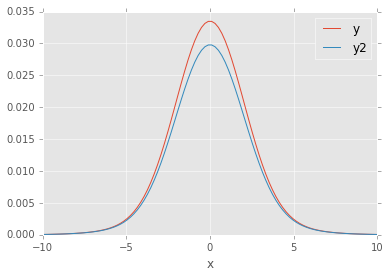

In [8]:
psfWidth = 2.0
generator = afwMath.DoubleGaussianFunction2D(psfWidth, psfWidth*1.75, 0.1)
y = [generator(x, 0) for x in np.linspace(-10., 10., 100)]
y2 = [generator(x, 1.) for x in np.linspace(-10., 10., 100)]
df = pd.DataFrame( {'x':np.linspace(-10., 10., 100), 'y':y, 'y2':y2} )
df.plot(x='x')

10000 (100, 100)


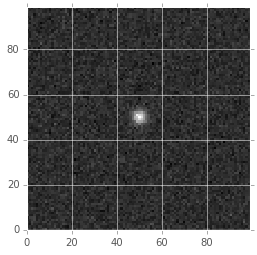

In [9]:
w = 100
h = 100
xc = 50.
yc = 50.

image = afwImage.MaskedImageF(w,h)
image.set(0)
array = image.getImage().getArray()
array[:,:] = np.random.randn(w,h)
# Set variance to 1.0
var   = image.getVariance()
var.set(1.0)

array  = image.getImage().getArray()
print array.size, array.shape

#imPos = np.ndarray( (100,100), buffer=np.array([ np.abs(i-xc)+np.abs(j-yc) for i in xrange(w) for j in xrange(h) ]) )                   
#array[:] = imPos/100.

imPos = np.ndarray( (w,h), buffer=np.array([ generator(i-xc,j-yc) for i in xrange(w) for j in xrange(h) ]) )
array[:] += imPos*500.

plt.imshow(np.rot90(array), cmap='gray', extent=(0,99,0,99), interpolation='none')
plt.show()

### Try this, from

http://cars9.uchicago.edu/software/python/lmfit/model.html#model.best_fit

[ 2.4042404   0.24494419  1.3467689 ]


/Users/dreiss/miniconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


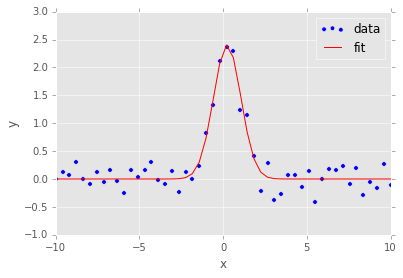

In [10]:
def gaussian(x, amp, cen, wid):
    return amp * np.exp(-(x-cen)**2. /wid)

from scipy.optimize import curve_fit
x = np.linspace(-10,10)
y = gaussian(x, 2.33, 0.21, 1.51) + np.random.normal(0, 0.2, len(x))

init_vals = [1, 0, 1]     # for [amp, cen, wid]
best_vals, covar = curve_fit(gaussian, x, y, p0=init_vals)
print best_vals

df = pd.DataFrame({'x': x, 'y': y, 'fit': gaussian(x, best_vals[0], best_vals[1], best_vals[2])})
ax = df.plot(x='x', y='y', kind='scatter', color='blue', label='data')
df.plot(x='x', y='fit', kind='line', color='red', label='fit', ax=ax)

##### To get lmfit, add my PYTHONUSERBASE to the PYTHONPATH:
```
addtopypath $HOME/PYTHONUSERBASE/lib/python2.7/site-packages
```

Note the stuff below seems to be mostly a wrapper around the scipy optimizer.

 - Adding parameter "amp"
 - Adding parameter "cen"
 - Adding parameter "wid"
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # function evals   = 37
    # data points      = 201
    # variables        = 3
    chi-square         = 8.482
    reduced chi-square = 0.043
[[Variables]]
    amp:   9.92388057 +/- 0.092750 (0.93%) (init= 5)
    cen:   6.20063555 +/- 0.008151 (0.13%) (init= 5)
    wid:   0.75532306 +/- 0.008151 (1.08%) (init= 1)
[[Correlations]] (unreported correlations are <  0.100)
    C(amp, wid)                  =  0.577 



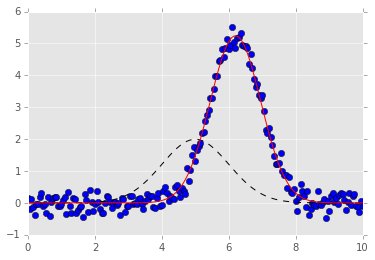

In [12]:
import lmfit

#data = loadtxt('model1d_gauss.dat')
#x = data[:, 0]
#y = data[:, 1]
#x = np.linspace(-10,10)
#y = gaussian(x, 2.33, 0.21, 1.51) + np.random.normal(0, 0.2, len(x))
x = np.linspace(0, 10, 201)

def gaussian(x, amp, cen, wid):
    "1-d gaussian: gaussian(x, amp, cen, wid)"
    return (amp/(np.sqrt(2*np.pi)*wid)) * np.exp(-(x-cen)**2 /(2*wid**2))

gmod = lmfit.Model(gaussian)
y = gmod.eval(x=x, amp=10, cen=6.2, wid=0.75) + np.random.normal(0, 0.2, len(x))
result = gmod.fit(y, x=x, amp=5, cen=5, wid=1)

print(result.fit_report())

plt.plot(x, y,         'bo')
plt.plot(x, result.init_fit, 'k--')
plt.plot(x, result.best_fit, 'r-')
plt.show()

### Let's look at `astropy`'s modeling and fitting stuff:

http://docs.astropy.org/en/stable/modeling/

#### Simple 2-D model fitting

Similarly to the 1-D example, we can create a simulated 2-D data dataset, and fit a polynomial model to it. This could be used for example to fit the background in an image.

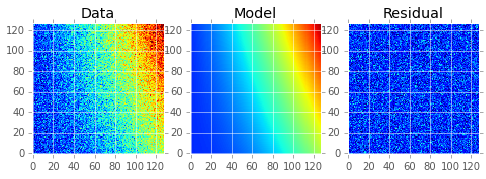

In [13]:
import warnings
import astropy.modeling as apMod

# Generate fake data
np.random.seed(0)
y, x = np.mgrid[:128, :128]
z = 2. * x ** 2 - 0.5 * x ** 2 + 1.5 * x * y - 1.
z += np.random.normal(0., 0.1, z.shape) * 50000.

# Fit the data using astropy.modeling
p_init = apMod.models.Polynomial2D(degree=2)
fit_p = apMod.fitting.LevMarLSQFitter()

with warnings.catch_warnings():
    # Ignore model linearity warning from the fitter
    warnings.simplefilter('ignore')
    p = fit_p(p_init, x, y, z)

# Plot the data with the best-fit model
plt.figure(figsize=(8, 2.5))
plt.subplot(1, 3, 1)
plt.imshow(z, origin='lower', interpolation='nearest', vmin=-1e4, vmax=5e4)
plt.title("Data")
plt.subplot(1, 3, 2)
plt.imshow(p(x, y), origin='lower', interpolation='nearest', vmin=-1e4,
           vmax=5e4)
plt.title("Model")
plt.subplot(1, 3, 3)
plt.imshow(z - p(x, y), origin='lower', interpolation='nearest', vmin=-1e4,
           vmax=5e4)
plt.title("Residual")

#### Compound models

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.83285936044
            Iterations: 14
            Function evaluations: 137
            Gradient evaluations: 14


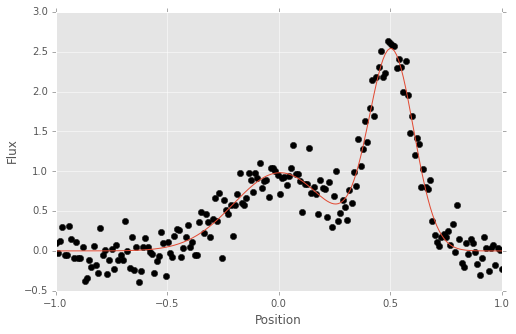

In [15]:
# Generate fake data
np.random.seed(42)
g1 = apMod.models.Gaussian1D(1, 0, 0.2)
g2 = apMod.models.Gaussian1D(2.5, 0.5, 0.1)
x = np.linspace(-1, 1, 200)
y = g1(x) + g2(x) + np.random.normal(0., 0.2, x.shape)

# Now to fit the data create a new superposition with initial
# guesses for the parameters:
gg_init = apMod.models.Gaussian1D(1, 0, 0.1) + apMod.models.Gaussian1D(2, 0.5, 0.1)
fitter = apMod.fitting.SLSQPLSQFitter()
gg_fit = fitter(gg_init, x, y)

# Plot the data with the best-fit model
plt.figure(figsize=(8,5))
plt.plot(x, y, 'ko')
plt.plot(x, gg_fit(x))
plt.xlabel('Position')
plt.ylabel('Flux')

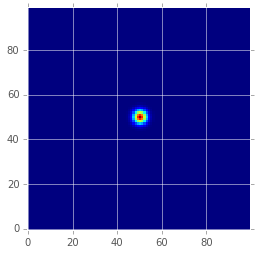

In [16]:
psfWidth = 2.0
generator = afwMath.DoubleGaussianFunction2D(psfWidth, psfWidth*1.75, 0.1)

#x = np.ndarray((w, h), buffer=np.array([w * i + j for i in xrange(w) for j in xrange(h)]), dtype=np.int64).flatten()
#y = np.ndarray((w, h), buffer=np.array([generator(i-xc,j-yc) for i in xrange(w) for j in xrange(h)])).flatten()

#np.divide(x, w) ## gives y (row) values
#np.mod(x, w) ## gives x (column) values
#y
#tmp = [generator(np.mod(xx, w).astype(np.float64) - xc, np.divide(xx, w).astype(np.float64) - yc) for xx in x]

w, h = 100, 100
xc, yc = 50., 50.

g1 = apMod.models.Gaussian2D(1, xc, yc, psfWidth, psfWidth)

y, x = np.mgrid[:100, :100]
z = g1(x, y)
plt.imshow(z, origin='lower', interpolation='nearest', vmin=0., vmax=z.max())

In [18]:
# Now to fit the data create a new 2d gaussian with initial
# guesses for the parameters:
gg_init = apMod.models.Gaussian2D(1, 53., 49., 2.5, 2.5)
fitter = apMod.fitting.SLSQPLSQFitter()
gg_fit = fitter(gg_init, x, y, z)
print gg_fit

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.69838421193e-09
            Iterations: 13
            Function evaluations: 109
            Gradient evaluations: 13
Model: Gaussian2D
Inputs: (u'x', u'y')
Outputs: (u'z',)
Model set size: 1
Parameters:
      amplitude        x_mean        y_mean    ...    y_stddev        theta     
    -------------- ------------- ------------- ... ------------- ---------------
    0.999991776477 50.0000178108 50.0000100948 ... 2.00003215434 -0.113219842978


### OK, this uses a combo of the example from astropy and lmfit. 

## 2-D Gaussian fit - it works!

In [19]:
psfWidth = 2.0
#generator = afwMath.DoubleGaussianFunction2D(psfWidth, psfWidth*1.75, 0.1)

w, h = 100, 100
xc, yc = 50., 50.
ht = 1.2

y, x = np.mgrid[:w, :h]
x = x.flatten()
y = y.flatten()
in_x = [x, y]

def gaussian2d(x, amp, xcen, ycen, sig1, sig2):
    """
    2-d double-gaussian: gaussian2d(x, amp, xcen, ycen, sig1, sig2)
    TBD: also variable ywid
    """
    #return (amp/(sqrt(2*pi)*wid)) * exp(-(x-cen)**2 /(2*wid**2))
    generator = afwMath.DoubleGaussianFunction2D(sig1, sig2, 0.1)
    zout = np.array([generator(x[0][i] - xcen, x[1][i] - ycen) for i in np.arange(len(x[0]))])
    zout *= amp / zout.max()
    return zout

#z = np.array([generator(in_x[0][i] - xc, in_x[1][i] - yc) for i in np.arange(len(in_x[0]))])
#z *= ht / z.max()
z = gaussian2d(in_x, ht, xc, yc, psfWidth, psfWidth*1.75)
z += np.random.normal(0., 0.2, x.shape)

gmod = lmfit.Model(gaussian2d)
%timeit -r1 gmod.fit(z, x=in_x, amp=1., xcen=52., ycen=49., sig1=1., sig2=2., verbose=False)
result = gmod.fit(z, x=in_x, amp=1., xcen=52., ycen=49., sig1=1., sig2=2.)

print(result.fit_report())

1 loops, best of 1: 831 ms per loop
 - Adding parameter "amp"
 - Adding parameter "xcen"
 - Adding parameter "ycen"
 - Adding parameter "sig1"
 - Adding parameter "sig2"
[[Model]]
    Model(gaussian2d)
[[Fit Statistics]]
    # function evals   = 62
    # data points      = 10000
    # variables        = 5
    chi-square         = 403.569
    reduced chi-square = 0.040
[[Variables]]
    amp:    1.23693518 +/- 0.125953 (10.18%) (init= 1)
    xcen:   50.0597386 +/- 0.131168 (0.26%) (init= 52)
    ycen:   49.8780359 +/- 0.131168 (0.26%) (init= 49)
    sig1:   2.13607913 +/- 0.109483 (5.13%) (init= 1)
    sig2:   1.38206026 +/- 1.828087 (132.27%) (init= 2)
[[Correlations]] (unreported correlations are <  0.100)
    C(amp, sig2)                 = -0.797 
    C(sig1, sig2)                = -0.439 



### We are now ready for dipole fitting

## Dipole fitting!!!

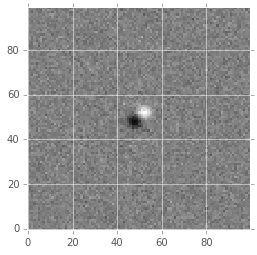

In [20]:
psfWidth = 2.0
#generator = afwMath.DoubleGaussianFunction2D(psfWidth, psfWidth*1.75, 0.1)

w, h = 100, 100
xc, yc = 50., 50.
ht = 2.2

y, x = np.mgrid[:w, :h]
x = x.flatten()
y = y.flatten()
in_x = [x, y]

## Note right now we are only fitting one amplitude and the 4 positions, not
##   anything related to the shape of the PSF!
def dipoleFunc(x, amp, xcenPos, ycenPos, xcenNeg, ycenNeg): #, sig1, sig2):
    """
    Dipole based on 2-d double-gaussian: 
    dipoleFunc(x, amp, xcenPos, ycenPos, xcenNeg, ycenNeg) #, sig1, sig2)
    """
    #return (amp/(sqrt(2*pi)*wid)) * exp(-(x-cen)**2 /(2*wid**2))
    generator = afwMath.DoubleGaussianFunction2D(psfWidth, psfWidth*1.75, 0.1)
    zout = np.array([generator(x[0][i] - xcenPos, x[1][i] - ycenPos) for i in np.arange(len(x[0]))])
    zout -= np.array([generator(x[0][i] - xcenNeg, x[1][i] - ycenNeg) for i in np.arange(len(x[0]))])
    zout *= amp / zout.max()
    return zout

#z = np.array([generator(in_x[0][i] - xc, in_x[1][i] - yc) for i in np.arange(len(in_x[0]))])
#z *= ht / z.max()
z = dipoleFunc(in_x, ht, xc+2., yc+2., xc-2., yc-2.) #, psfWidth, psfWidth*1.75)
z += np.random.normal(0., 0.2, x.shape) #* (0.1 + np.sqrt(np.abs(z)))
plt.imshow(z.reshape(w, h), origin='lower', interpolation='none', cmap='gray', vmin=-ht, vmax=ht)

In [21]:
gmod = lmfit.Model(dipoleFunc)
%timeit -r1 gmod.fit(z, x=in_x, amp=1., xcenPos=53.1, ycenPos=52.8, xcenNeg=47.2, ycenNeg=47.5, verbose=False)
result = gmod.fit(z, x=in_x, amp=1., xcenPos=53.1, ycenPos=52.8, xcenNeg=47.2, ycenNeg=47.5) #, sig1=1., sig2=2.)

print(result.fit_report())

1 loops, best of 1: 873 ms per loop
 - Adding parameter "amp"
 - Adding parameter "xcenPos"
 - Adding parameter "ycenPos"
 - Adding parameter "xcenNeg"
 - Adding parameter "ycenNeg"
[[Model]]
    Model(dipoleFunc)
[[Fit Statistics]]
    # function evals   = 33
    # data points      = 10000
    # variables        = 5
    chi-square         = 401.961
    reduced chi-square = 0.040
[[Variables]]
    amp:       2.17240697 +/- 0.043944 (2.02%) (init= 1)
    xcenPos:   52.0225197 +/- 0.079678 (0.15%) (init= 53.1)
    ycenPos:   52.0183948 +/- 0.079307 (0.15%) (init= 52.8)
    xcenNeg:   47.9576990 +/- 0.079678 (0.17%) (init= 47.2)
    ycenNeg:   48.0754453 +/- 0.079307 (0.16%) (init= 47.5)
[[Correlations]] (unreported correlations are <  0.100)
    C(ycenPos, xcenNeg)          = -0.354 
    C(xcenPos, ycenNeg)          = -0.354 
    C(amp, xcenPos)              = -0.278 
    C(amp, ycenPos)              = -0.268 
    C(xcenPos, xcenNeg)          = -0.221 
    C(amp, xcenNeg)              = 

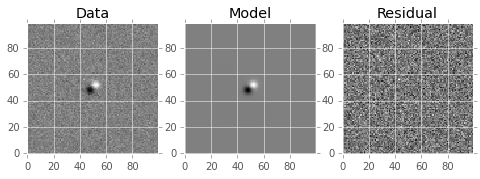

In [22]:
plt.figure(figsize=(8, 2.5))
plt.subplot(1, 3, 1)
plt.imshow(z.reshape(w, h), origin='lower', interpolation='none', cmap='gray', vmin=-ht, vmax=ht)
plt.title("Data")
plt.subplot(1, 3, 2)
plt.imshow(result.best_fit.reshape(w, h), origin='lower', interpolation='none', cmap='gray', vmin=-ht, vmax=ht)
plt.title("Model")
plt.subplot(1, 3, 3)
plt.imshow(z.reshape(w, h) - result.best_fit.reshape(w, h), origin='lower', cmap='gray', interpolation='none')
plt.title("Residual")